# Fitting Gaussian Mixture on a data sample using features from a pre-trained Model

Consider the set of all $K$-dimensional categorical distributions given by

\begin{equation}
    \mathcal{C} = \bigg\{ \mathbf{c} \in \mathbb{R}^{K}_{+} :  \mathbf{c} \geq 0,\ \mathbf{c}^{\rm T}\mathbf{1} = 1 \bigg\} \subset \mathbb{R}^{K}_{+}.
\end{equation}

In this code we consider the set of gaussian mixtures for the set of distributions $\{ \nu_{i} \}_{i = 1}^{K} $ given by given by:
\begin{equation}
		\mathcal{GM} \bigg(\mathbf{c}, \{ \nu_{i} \}_{i = 1}^{K} \bigg) = \bigg\{ \sum_{i = 1}^{K} c_{i} \nu_{i}, \ \forall \mathbf{c} \in \mathcal{C} \bigg\}
	\end{equation}
For the mixture of gaussian distributions $\{ \nu_{i} \}_{i = 1}^{K} $ with means $\{ \mu_{i} \}_{i = 1}^{K} $ and covariance matrices $\{ \Sigma_{i} \}_{i = 1}^{K} $, mixture means and covariance are


\begin{gather*}
 \bar{\mu}_{\mathbf{c}} = \sum_{k =1}^{K} c_{k} \mu_{k}\  \text{,  }
 \,\,\,\, \Sigma_{\mathbf{c}} = \sum_{k =1}^{K} c_k \big( \Sigma_k + \mu_{k} \mu_{k}^{\top} - \bar{\mu}_{\mathbf{c}} \bar{\mu}_{\mathbf{c}}^\top \big)
\end{gather*}

For a data sample $\nu_{*}$, we employed Frank-Wolfe Based optimization routine to find the best matching mean, covaraince pair from the the set of all possible mixtures of $\{ \nu_{i} \}_{i = 1}^{K} $ to fit with mean  and covaraince of $\nu_{*}$.

In [4]:
#%%
import numpy as np
import scipy as sp
from scipy.optimize import check_grad
from scipy.optimize import approx_fprime
from matplotlib import pyplot as plt
import tensorflow as tf
#%%
'''
    mx: mean of source with size: n x 1
    M: means of target distributions with size: n x K, where K indicates number of data-classes.
    covx: covariance matrix of source with size: n x 1
    covM: array of covariance matrices of target distributions with size: K x n x n, where K indicates number of data-classes.
    max_iter: max_iterations of Frank Wolfe
    tol: tolerance for gradient check
    divg: divergences to be used for computations
    max_iter: maximum of frank wolfe iterations
    min_tol: minimum tolerance for gardient checking
    print_iter: priniting values of maixture weights for each iteration
'''
class GM_FW:
    def __init__(self, mux, M, covx, covM, c0,  max_iter = None, min_tol = None, print_iter = None):
        # instance attributes which should be initilzied with class
        self.mux = mux
        self.M = M
        self.covx = covx
        self.covM = covM
        self.c0 = c0

        
        self.sqrt_covx = sp.linalg.sqrtm(covx)
        self.I = np.identity(np.size(mux))

        # attributes to be keep track of computations
        self.c = np.zeros_like(c0)
        self.mubar = np.zeros_like(mux)
        self.hat_covM = self.covM + self.M.T.reshape([self.M.shape[1], self.M.shape[0], 1]) @ self.M.T.reshape([M.shape[1], 1, M.shape[0]])
        self.tilde_covM = np.zeros_like(covM)
        self.tilde_sigma_c = np.zeros([covM.shape[1], covM.shape[2]])
        self.zeta_c = np.zeros([covM.shape[1], covM.shape[2]])
        
        if max_iter == None:
            self.max_iter = 1000
        else:
            self.max_iter = max_iter

        if min_tol == None:
            self.min_tol = 1e-6
        else:
            self.min_tol = min_tol
        
        if print_iter == None:
            self.print_iter = False
        elif print_iter == False:
            self.print_iter = False
        elif print_iter == True:
            self.print_iter = True
        else:
            self.print_iter = False

        self.obj_vals = np.zeros([self.max_iter])
        self.grads = np.zeros([self.max_iter, np.size(self.c)])
        self.weights = np.zeros([self.max_iter, np.size(self.c)])
    
    def reset_values(self):
        # self.mux = mux
        # self.M = M
        # self.covx = covx
        # self.covM = covM
        # self.c0 = c0
        # self.divg = divg

        self.sqrt_covx = sp.linalg.sqrtm(self.covx)
        self.I = np.identity(np.size(self.mux))

        # attributes to be keep track of computations
        self.c = np.zeros_like(self.c0)
        self.mubar = np.zeros_like(self.mux)
        self.hat_covM = self.covM + \
            self.M.T.reshape([self.M.shape[1], self.M.shape[0], 1]
                         ) @ self.M.T.reshape([self.M.shape[1], 1, self.M.shape[0]])
        self.tilde_covM = np.zeros_like(self.covM)
        self.tilde_sigma_c = np.zeros([self.covM.shape[1], self.covM.shape[2]])
        self.zeta_c = np.zeros([self.covM.shape[1], self.covM.shape[2]])

        # if max_iter == None:
        #     self.max_iter = 1000
        # else:
        #     self.max_iter = max_iter

        # if min_tol == None:
        #     self.min_tol = 1e-6
        # else:
        #     self.min_tol = min_tol

        # if print_iter == None:
        #     self.print_iter = False
        # elif print_iter == False:
        #     self.print_iter = False
        # elif print_iter == True:
        #     self.print_iter = True
        # else:
        #     self.print_iter = False

        self.obj_vals = np.zeros([self.max_iter])
        self.grads = np.zeros([self.max_iter, np.size(self.c)])
        self.weights = np.zeros([self.max_iter, np.size(self.c)])

    def initialize_weights(self):
        self.c = self.c0

    def update_mubar(self):
        self.mubar =  np.sum(self.c[np.newaxis,:] * self.M, axis = 1, keepdims = True)
    
    def compute_mmd(self):
        return np.linalg.norm(self.mux - self.M@self.c)**2
    
    def compute_mmd_grad(self):
        return 2*self.M.T @ (self.M @ self.c[:,np.newaxis] - self.mux)

    def update_tilde_covM(self):
        self.tilde_covM = self.hat_covM - (self.mubar@self.mubar.T)[np.newaxis,:,:]

        
    def update_tilde_sigma_c(self):
        self.tilde_sigma_c = np.sum(
            self.c[:, np.newaxis, np.newaxis] * self.tilde_covM, axis=0)
            
    def update_zeta_c(self):
        temp = sp.linalg.sqrtm(self.sqrt_covx @ self.tilde_sigma_c @ self.sqrt_covx)
        self.zeta_c = (temp + temp.T)/2

    def compute_bures(self):
        temp =  np.trace( self.covx + self.tilde_sigma_c - 2 * self.zeta_c )
        return temp
    
    def compute_bures_grad_tilde_sigma_c(self):
        return self.I - self.sqrt_covx @ sp.linalg.pinv(self.zeta_c) @ self.sqrt_covx
    
    def compute_bures_grad_c(self):
        G = self.compute_bures_grad_tilde_sigma_c()
        rho = (self.M.T.reshape(self.M.shape[1], self.M.shape[0],1) @ self.mubar.T) + self.mubar @ self.M.T.reshape(self.M.shape[1],1,self. M.shape[0])
        temp = np.sum(G[np.newaxis, :, :] * (self.hat_covM - rho ), axis=(1, 2))[:, np.newaxis]
        return temp
    
    def compute_frechet(self):
        B = self.compute_bures()
        mmd = self.compute_mmd()
        return B + mmd

    def compute_frechet_grad(self):
        GB = self.compute_bures_grad_c()
        Gmmd = self.compute_mmd_grad()
        return GB + Gmmd


    def FW_frechet_routine(self):
        self.initialize_weights()
        for i in range(0, self.max_iter):
            self.update_mubar()
            self.update_tilde_covM()
            self.update_tilde_sigma_c()
            self.update_zeta_c()
            self.compute_bures_grad_c()
            self.obj_vals[i] = self.compute_frechet()
            g = self.compute_frechet_grad()
            #print(g)
            self.grads[i, :] = np.squeeze(g)
            s = np.zeros_like(self.c)
            idx = np.argmin(g)
            s[idx] = 1
            gamma = 2 / (2 + i)
            self.c = (1 - gamma) * self.c + gamma * s
            
            self.weights[i, :] = self.c
            if self.print_iter == True:
                print("iter = ",i)
                print(self.c)
    
    def FW_bures_routine(self):

        # commented part must be uncommented for gradient-checking
        
        # def bures_grad_num(c_i, epsilon):
            
        #     num_grad = np.zeros_like(c_i)
        #     I = np.identity(c_i.size)
        #     for i in range(0, num_grad.size):
        #         num_grad[i] = (bures(c_i + epsilon * I[:,i]) - bures(c_i) ) / epsilon
            
        #     return num_grad
            

        # def bures(c_i):
            
        #     mubar =  np.sum(c_i[np.newaxis,:] * self.M, axis = 1, keepdims = True)
        #     # k, n, n - n,n => k,n,n
        #     tilde_covM = self.hat_covM 
        #     #k,.,. * k,n,n => n,n
        #     tilde_sigma_c = np.sum(c_i[:, np.newaxis, np.newaxis] * tilde_covM, axis=0) - mubar@mubar.T

        #     #n,n
        #     zeta_ci = sp.linalg.sqrtm(self.sqrt_covx @ tilde_sigma_c @ self.sqrt_covx)

        #     #n,n
        #     zeta_ci = (zeta_ci + zeta_ci.T)/2

        #     #scalar
        #     temp =  np.trace( tilde_sigma_c + self.covx  - 2 * zeta_ci )
        #     return temp
        
        # def bures_grad(c_i):

        #     mubar =  np.sum(c_i[np.newaxis,:] * self.M, axis = 1, keepdims = True)

        #     tilde_covM = self.hat_covM - (mubar@mubar.T)[np.newaxis,:,:]

        #     tilde_sigma_c = np.sum(c_i[:, np.newaxis, np.newaxis] * tilde_covM, axis=0)

        #     zeta_ci = sp.linalg.sqrtm(self.sqrt_covx @ tilde_sigma_c @ self.sqrt_covx)
        #     zeta_ci = (zeta_ci + zeta_ci.T)/2

        #     G = self.I - self.sqrt_covx @ np.linalg.pinv(zeta_ci) @ self.sqrt_covx

        #     rho = (M.T.reshape(M.shape[1],M.shape[0],1) @ mubar.T) +  mubar @ M.T.reshape(M.shape[1],1,M.shape[0])

        #     return np.sum(G[np.newaxis, :, :] * (self.hat_covM - rho ), axis=(1, 2))
            

        self.initialize_weights()
        for i in range(0, self.max_iter):
            self.update_mubar()
            self.update_tilde_covM()
            self.update_tilde_sigma_c()
            self.update_zeta_c()
            self.obj_vals[i] = self.compute_bures()
            g = self.compute_bures_grad_c()
            
            
            # print("g")
            # print(np.squeeze(g))
            # c_i = self.c
            
            # print(np.squeeze(bures_grad(c_i)))
            #  print(np.squeeze(self.compute_bures_grad_c()))

            # eps = 10 * np.sqrt(np.finfo(float).eps)
            # ga = sp.optimize.approx_fprime(c_i, bures, np.array(eps*np.ones(np.size(g))).T)
            # ga = bures_grad_num(c_i, eps)
            # print("ga")
            # print(ga)
            
            # print(sp.optimize.check_grad(bures, bures_grad, c_i))
            
            s = np.zeros_like(self.c)
            idx = np.argmin(g)
            s[idx] = 1
            gamma = 2 / (2 + i)
            self.c = (1 - gamma) * self.c + gamma * s
            self.grads[i, :] = np.squeeze(g)
            self.weights[i, :] = self.c

            if self.print_iter == True:
                print("iter =  ",i)
                print(self.c)

    def FW_MMD_routine(self):
        
        # commented part must be uncommented for gradient-checking
        
        # def mmd(c_i):
        #     return (np.linalg.norm(self.M@c_i[:,np.newaxis] - self.mux))**2

        # def mmd_grad(c_i):
        #     return np.squeeze(2 * self.M.T @ (self.M @ c_i[:,np.newaxis] - self.mux))
        
        self.initialize_weights()
        for i in range(0, self.max_iter):
            self.update_mubar()
            self.update_tilde_covM()
            self.obj_vals[i] = self.compute_mmd()

            g = self.compute_mmd_grad()

            # print("g")
            # c_i = self.c
            # print(np.squeeze(mmd_grad(c_i)))
            # #print(np.squeeze(self.compute_mmd_grad()))

            # eps = np.sqrt(np.finfo(float).eps) * 100
            
            # print("ga")
            # ga = sp.optimize.approx_fprime(c_i, mmd, np.array([eps ,eps, eps]).T)
            # print(ga)

            # print(sp.optimize.check_grad(mmd, mmd_grad, c_i))

            s = np.zeros_like(self.c)
            idx = np.argmin(g)
            s[idx] = 1
            gamma = 2 / (2 + i)
            self.c = (1 - gamma) * self.c  + gamma * s 
            self.grads[i,:] = np.squeeze(g)
            self.weights[i,:] = self.c

            if self.print_iter == True:
                print("iter = ",i)
                print(self.c)


def Hellinger(p, q):
  '''
  Function to evaluate Hellinger Distance between distributions categorical distributions p and q
  input: distributions p and q
  outputs: Hillnger distance between p and q

  '''
  assert np.all(p >= 0), "first distribution must be non-negative"
  assert np.all(q >= 0), "second distribution must be non-negative"
  assert p.size == q.size, "input vectors must be of same size"

  p = p.reshape([p.size, 1])
  q = q.reshape([q.size, 1])

  return (1/np.sqrt(2)) * np.linalg.norm(np.sqrt(p) - np.sqrt(q))


In [85]:
# import numpy as np
# import scipy as sp

# M = np.array([[0, -0.5, 0.5],[1, 0, 0]])
# # M = np.array([[0, 0, 0], [0, 0, 0]])
# #M = np.ones_like(M)
# mux = np.array([[np.sqrt(3)/2], [np.sqrt(3)/2] ])
# covx = np.array([[10,6],[6,8]])
# covM = np.zeros([3,2,2])
# covM[0] = np.array([[1, 0.5],[0.5, 1]])
# covM[1] = np.array([[5, 0.6], [0.6, 7]])
# covM[2] = np.array([[4, 1], [1, 2]])
# c0 = np.ones(3)/3
 
# iterations = 10

# test = GM_FW(mux, M, covx, covM, c0, max_iter = iterations, print_iter = True)
# test.reset_values()
# test.FW_bures_routine()
# #test.FW_frechet_routine()



In [86]:
# num_ptx = 10
# dim = 100
# # M = np.random.rand(dim, num_ptx)
# M = np.zeros([dim, num_ptx])
# # M = np.ones_like(M)
# mux = np.random.rand(dim).reshape([dim, 1])
# A = np.random.rand(dim, dim)
# covx = A @ A.T
# covM = np.zeros([num_ptx, dim, dim])
# for i in range(0, num_ptx):
#     A = np.random.rand(dim, dim)
#     covM[i] = A @ A.T

# iterations = 10

# c0 = np.ones(num_ptx)/(num_ptx)
# test = GM_FW(mux, M, covx, covM, c0, max_iter=iterations, print_iter = True)
# #test.reset_values()
# test.FW_bures_routine()


In [316]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras
from numpy.random import exponential
from sklearn.decomposition import PCA

# Data Processing before PCA 
# N_samples indicates the number of samples to be drawn from data
N_samples = 500
# sample_sz indicates the number of samples to be drawn from data
sample_sz = 400

tf.keras.datasets.mnist.load_data(path="mnist.npz")
(X_train, y), (X_test, yt) = keras.datasets.mnist.load_data()

X_train = X_train / 255
y = y / 1
X_test = X_test / 255
yt = yt / 1

X = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])
Xt = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])

# PCA from scikit-learn
PCA_components = 130
pca = PCA(n_components = PCA_components)
pca.fit(X)
# np.sum(pca.explained_variance_ratio_)
P = pca.components_
X_hat = X@P.T
Xt_hat = Xt@P.T

# Creation and Testing and Training samples

n_classes = np.size(np.unique(y))
means_i = np.zeros([n_classes, PCA_components])
covs_i = np.zeros([n_classes, PCA_components, PCA_components])

Training_Data = {}
Training_Lables = {}
for i in range(0, 10):
  Training_Data[str(i)] = X_hat[y == i]
  Training_Lables[str(i)] = y[y == i]
  means_i[i] = np.mean(Training_Data[str(i)], axis = 0)
  covs_i[i] = np.cov(Training_Data[str(i)].T)

Testing_Data = {}
Testing_Lables = {}
for i in range(0, 10):
  Testing_Data[str(i)] = Xt_hat[yt == i]
  Testing_Lables[str(i)] = yt[yt == i]

FW_iterations = 1000
Hellinger_metric = np.zeros([N_samples, FW_iterations])
Grads = np.zeros([N_samples, FW_iterations, n_classes])
Optimal_weights = np.zeros([N_samples, FW_iterations, n_classes])
Sample_distributions = np.zeros([N_samples, n_classes])

for sample_iter in range(0, N_samples): 
  # sampling uniformly on probability simplex
  sz = exponential(1, n_classes)
  s = sz / np.sum(sz)
  ints = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
  p = s
  counts_sample = np.floor(sample_sz * p)
  Sample_distributions[sample_iter,:] = counts_sample / np.sum(counts_sample)

  sample = np.empty([0, PCA_components], dtype = float)
  sample_labels = np.empty(0, dtype = float)
  counter = 0
  for k in ints:
    idx = np.random.choice(np.arange(0, Testing_Data[str(k)].shape[0]), size = np.int(counts_sample[counter]), replace = False )
    sample = np.append(sample, Testing_Data[str(k)][idx], axis = 0)
    sample_labels = np.append(sample_labels, Testing_Lables[str(k)][idx], axis = 0)
    counter = counter + 1

  mean_x = np.mean(sample, axis = 0)
  covx = np.cov(sample.T)

  mux = mean_x[np.newaxis,:].T
  M = means_i.T
  covM = covs_i
  
  # Frank_Wolfe is invoked
  c0 = np.ones(n_classes)/n_classes
  
  MNIST = GM_FW(mux, M, covx, covM, c0, max_iter = FW_iterations, print_iter = False)
  
  MNIST.FW_frechet_routine()
  Optimal_weights[sample_iter] = MNIST.weights
  Grads[sample_iter] = MNIST.grads
  print("sample = ", sample_iter)

for i in range(0, N_samples):
    for j in range(0, FW_iterations):
        Hellinger_metric[i, j] = Hellinger(Sample_distributions[i], Optimal_weights[i, j, :])


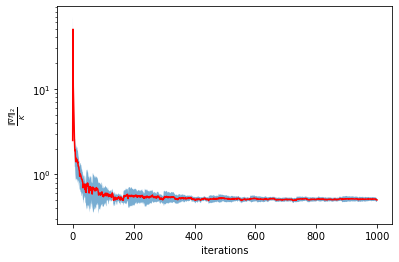

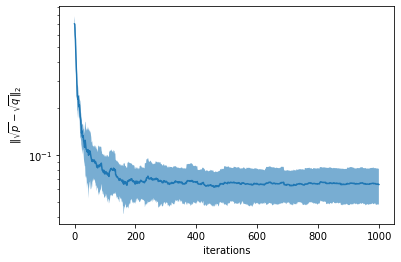

In [315]:
fig, ax = plt.subplots()


iters = np.array([k for k in range(0, FW_iterations )])
Grads_norms = np.linalg.norm(Grads/n_classes, axis=0)
Grads_norms_means = np.mean(Grads_norms, axis = 1)
Grads_norms_std = np.std(Grads_norms, axis=1)
plt.semilogy(iters, Grads_norms_means, color = 'r')
plt.fill_between(iters, Grads_norms_means - Grads_norms_std,
                Grads_norms_means + Grads_norms_std, alpha = 0.6)
plt.xlabel("iterations")
plt.ylabel('$ \\frac{\Vert\\nabla f \Vert_{2}}{K}$')
plt.show()

Hellinger_means = np.mean(Hellinger_metric.T, axis=1)
Hellinger_std = np.std(Hellinger_metric.T, axis=1)
#plt.semilogy(iters, (Hellinger_metric.T))
plt.semilogy(iters, Hellinger_means)

plt.fill_between(iters, Hellinger_means - Hellinger_std,
                 Hellinger_means + Hellinger_std, alpha=0.6)
plt.xlabel("iterations")
plt.ylabel(
    "$\ \Vert \sqrt{p} - \sqrt{q} \Vert_{2}$")
plt.show()


In [313]:
Hellinger_std.shape

(1000,)

In [310]:
Hellinger_metric.shape


(10, 1000)

In [186]:
MNIST.weights.shape

(100, 10)

In [133]:
MNIST.c

array([0.0571018 , 0.10604391, 0.07813174, 0.07201597, 0.11667864,
       0.02332136, 0.20525349, 0.04277046, 0.1687505 , 0.12993214])

In [134]:
np.sum(np.floor(s*400))

396.0

In [140]:
Hellinger(MNIST.c, counts_sample/np.sum(counts_sample))


0.044543510316506114

In [139]:
counts_sample/np.sum(counts_sample)

array([0.05555556, 0.10858586, 0.1010101 , 0.06313131, 0.0959596 ,
       0.03282828, 0.20707071, 0.03535354, 0.16919192, 0.13131313])

In [143]:
counts_sample

array([22., 43., 40., 25., 38., 13., 82., 14., 67., 52.])

In [146]:
MNIST.c * np.sum(counts_sample)


array([22.61231138, 41.99338922, 30.94016766, 28.51832335, 46.20474251,
        9.23525749, 81.28038323, 16.9371018 , 66.8251976 , 51.45312575])

In [194]:
MNIST.weights.shape

(500, 10)

In [195]:
s

array([0.04322947, 0.10684467, 0.1742274 , 0.01120338, 0.13016562,
       0.1717567 , 0.22759056, 0.06086385, 0.0647902 , 0.00932815])

In [214]:
Sample_distributions.shape

(10, 10)

In [217]:
Optimal_weights.shape

(10, 500, 10)

(10, 500)

In [204]:
Grads.shape

(10, 2, 10)

In [250]:
iters

array([ True])

In [252]:
[k for k in range(0, FW_iterations)]


[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
